### check GPU

In [1]:
import tensorflow as tf

print("Is there a GPU available: "),
print(tf.config.experimental.list_physical_devices("GPU"))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load text into datasets

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import tensorflow_datasets as tfds
import os

base_path = './data'
raw_data_path = 'rt-polaritydata'

parent_dir = os.path.join(base_path, raw_data_path)
FILE_NAMES = ['rt-polarity-pos.txt', 'rt-polarity-neg.txt']

def labeler(example, index):
  return example, tf.cast(index, tf.int64)

labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
    text_dir = os.path.join(parent_dir, file_name)
    print(text_dir)
    
    lines_dataset = tf.data.TextLineDataset(text_dir)
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

labeled_data_sets

./data/rt-polaritydata/rt-polarity-pos.txt
./data/rt-polaritydata/rt-polarity-neg.txt


[<MapDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 <MapDataset shapes: ((), ()), types: (tf.string, tf.int64)>]

In [3]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64
TAKE_SIZE = 5000

all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

for ex in all_labeled_data.take(5):
  print(ex)

(<tf.Tensor: id=53, shape=(), dtype=string, numpy=b"there's not a single jump-in-your-seat moment and believe it or not , jason actually takes a backseat in his own film to special effects . ">, <tf.Tensor: id=54, shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: id=55, shape=(), dtype=string, numpy=b"kirshner and monroe seem to be in a contest to see who can out-bad-act the other . ( kirshner wins , but it's close . ) ">, <tf.Tensor: id=56, shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: id=57, shape=(), dtype=string, numpy=b'by no means a slam-dunk and sure to ultimately disappoint the action fans who will be moved to the edge of their seats by the dynamic first act , it still comes off as a touching , transcendent love story . '>, <tf.Tensor: id=58, shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: id=59, shape=(), dtype=string, numpy=b"instead of accurately accounting a terrible true story , the film's more determined to become the next texas chainsaw massacre . but what about the countless 

### Build vocabulary

In [4]:
import tensorflow_datasets as tfds

tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

18369

### Encode examples

In [5]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [6]:
example_text = next(iter(all_labeled_data))[0].numpy()
print(example_text)

b"there's not a single jump-in-your-seat moment and believe it or not , jason actually takes a backseat in his own film to special effects . "


In [7]:
encoded_example = encoder.encode(example_text)
print(encoded_example)

[2803, 12906, 11165, 3131, 15047, 16760, 878, 16337, 17814, 4123, 2094, 8226, 8473, 10792, 11165, 14325, 7672, 15458, 3131, 2434, 878, 14483, 2150, 11494, 1320, 18140, 15985]


In [8]:
print(all_labeled_data)

<ShuffleDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [9]:
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

def encode_map_fn(text, label):
  return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

all_encoded_data = all_labeled_data.map(encode_map_fn)

### Split the dataset into test and train batches

In [10]:
train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([-1],[]))

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE, padded_shapes=([-1],[]))

train_data

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>

In [11]:
sample_text, sample_labels = next(iter(test_data))

sample_text[0], sample_labels[0]

(<tf.Tensor: id=21634, shape=(41,), dtype=int64, numpy=
 array([ 2803, 12906, 11165,  3131, 15047, 16760,   878, 16337, 17814,
         4123,  2094,  8226,  8473, 10792, 11165, 14325,  7672, 15458,
         3131,  2434,   878, 14483,  2150, 11494,  1320, 18140, 15985,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])>,
 <tf.Tensor: id=21638, shape=(), dtype=int64, numpy=1>)

In [12]:
vocab_size += 1

### Build the model

In [13]:
model = tf.keras.Sequential()

In [14]:
model.add(tf.keras.layers.Embedding(encoder.vocab_size, 16))

In [15]:
model.add(tf.keras.layers.GlobalAveragePooling1D())

In [16]:
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          293936    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 293,953
Trainable params: 293,953
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Train the model

In [20]:
history = model.fit(train_data,
                    epochs=100,
                    validation_data=test_data,
                    validation_steps=30,
                    callbacks=[tensorboard_callback])

Epoch 1/100
      1/Unknown - 3s 3s/step - loss: 0.6930 - accuracy: 0.5156WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.284215). Check your callbacks.
89/89 [==============================] - 4s 41ms/step - loss: 0.6917 - accuracy: 0.5297 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
89/89 [==============================] - 2s 27ms/step - loss: 0.6846 - accuracy: 0.7428 - val_loss: 0.6844 - val_accuracy: 0.6547
Epoch 3/100
89/89 [==============================] - 2s 27ms/step - loss: 0.6724 - accuracy: 0.7566 - val_loss: 0.6759 - val_accuracy: 0.6714
Epoch 4/100
89/89 [==============================] - 2s 28ms/step - loss: 0.6538 - accuracy: 0.7833 - val_loss: 0.6644 - val_accuracy: 0.6786
Epoch 5/100
89/89 [==============================] - 2s 27ms/step - loss: 0.6309 - accuracy: 0.7858 - val_loss: 0.6518 - val_accuracy: 0.6880
Epoch 6/100
89/89 [==============================] - 2s 27ms/step - loss: 0.6047 - accuracy: 0.8038 - 

#### Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(test_data)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

#### Create a graph of accuracy and loss over time

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

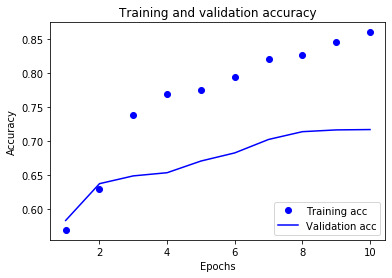

In [23]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [4]:
from hbconfig import Config

In [5]:
Config("rt-polarity")

In [6]:
Config

Read config file name: ./config/rt-polarity
{
    "data": {
        "type": "rt-polarity",
        "base_path": "data/",
        "raw_data_path": "rt-polaritydata/",
        "processed_path": "rt-polarity_processed_data",
        "testset_size": 2000,
        "num_classes": 2,
        "PAD_ID": 0
    },
    "model": {
        "batch_size": 64,
        "embed_type": "rand",
        "pretrained_embed": "",
        "embed_dim": 300,
        "num_filters": 256,
        "filter_sizes": [
            2,
            3,
            4,
            5
        ],
        "dropout": 0.5
    },
    "train": {
        "learning_rate": 1e-05,
        "train_steps": 20000,
        "model_dir": "logs/rt-polarity",
        "save_checkpoints_steps": 100,
        "loss_hook_n_iter": 100,
        "check_hook_n_iter": 100,
        "min_eval_frequency": 100,
        "print_verbose": true,
        "debug": false
    },
    "slack": {
        "webhook_url": ""
    }
}